In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Private DNS,222.602118,11.715901,17.353410,19
Todd Ideas,245.651270,61.412818,85.375546,4
RAG Project,629.207935,39.325496,52.275590,16
Azure AD Authentication,843.817175,64.909013,123.270022,13
Azure Functions + Visual Studio,1051.341957,80.872458,285.933550,13
Email Auth and Security,1058.912233,88.242686,205.018339,12
Azure DevOps Pipelines,1182.201512,45.469289,107.588488,26
Open Source/GitHub,1205.191079,75.324442,184.942482,16
Audit Report Tracker (Sharepoint List),1305.416931,108.784744,375.642757,12
Asynchronous Python,1501.182136,32.634394,51.872090,46


# Histogram

sum of ages: ~47223.00


<Axes: >

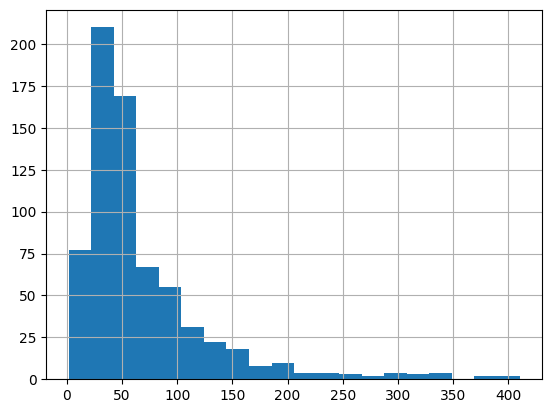

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [7]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [8]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [9]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [10]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [11]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [12]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [13]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 695
Total card age: 47223.00


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
91,Logging in Python,Q: How can you configure Python's logging to o...,293e680688510b291b7b3691786112ec,-385.164561,-116.407105,385.164561,4074.248684,0.902746,0,0
92,Logging in Python,Q: What is the advantage of using logging.getL...,e63d3ef375f4f0905315b7f337ed7eff,-292.714678,-116.407105,385.164561,4074.248684,0.902746,3,0
93,Logging in Python,Q: How can you include exception tracebacks in...,6a344b1ab62495533fc42ded0c61a8d8,-175.522076,-116.407105,385.164561,4074.248684,0.902746,6,0
569,Logging in Python,Q: Which logging level is appropriate for a me...,34aa335f159554e1fa43ef4942a6303b,-152.933433,-116.407105,385.164561,4074.248684,0.902746,9,0
95,Logging in Python,Q: What should you do to ensure that logging.b...,4d3218f8dc6a67fac7f558d2f82b88a1,-144.662099,-116.407105,385.164561,4074.248684,0.902746,12,0
96,Logging in Python,Q: Why should log files be secured with approp...,dd529ab0ee580346b944822dbffb1e10,-89.321164,-116.407105,385.164561,4074.248684,0.902746,15,0
572,Logging in Python,Q: How does using hierarchical logger names he...,58b80d916405c7331fe4824da8fb0090,-64.715658,-116.407105,385.164561,4074.248684,0.902746,18,0
98,Logging in Python,"Q: What is the purpose of using hierarchical, ...",9b892d486d33c614f18eea356f583d7c,-58.808993,-116.407105,385.164561,4074.248684,0.902746,21,0
574,Logging in Python,Q: What is a practical example of using a cust...,cad2f074a1c36fc7f83f45f8422d744d,-49.545489,-116.407105,385.164561,4074.248684,0.902746,24,0
100,Logging in Python,Q: What happens if you add multiple handlers t...,f564160a3da47c6ba6a49260ea6dd962,-39.341263,-116.407105,385.164561,4074.248684,0.902746,27,0


## Age Max

In [14]:
# n = 1
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# # existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [15]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [16]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [17]:
existing_cards.sort_values('age').head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
158,Debugging in VS Code,Debugger API\nAn application programming inter...,379ed80170d7da4e8ca2e7b1a4b9527c,-410.221781,-90.903299,410.221781,1727.162680,0.358778,0,0
67,PnP PowerShell,New-PnPList (PnP.PowerShell)\nCreates a new Sh...,9d9dc3700f5078d8eaff9507709eaacb,-390.367691,-58.594729,390.367691,4160.225761,0.380895,0,0
91,Logging in Python,Q: How can you configure Python's logging to o...,293e680688510b291b7b3691786112ec,-385.164561,-116.407105,385.164561,4074.248684,0.902746,0,0
186,Audit Report Tracker (Sharepoint List),Item (SharePoint List Item)\nDefinition: A sin...,d0ce8d0da3df8f92b4ff3ca95fd426ca,-375.642757,-108.784744,375.642757,1305.416931,0.693589,0,0
23,JavaScript Concepts,Express.js: A minimalist web framework for Nod...,425c10164d26897fdad3f9d7c2c6f523,-346.152917,-87.102871,346.152917,4616.452153,0.484414,0,0
311,PnP PowerShell,AppInv.aspx\nA SharePoint page used to grant a...,ffb4c4ea52b6951b0ba17c6ec30a0956,-343.842931,-58.594729,390.367691,4160.225761,0.380895,1,1
134,FSLogix,Cloud Cache uses the locally mounted container...,395fe6c9edfadeac3e8be549b66ded66,-330.908989,-109.793107,330.908989,2525.241455,0.562444,0,0
165,WSL + Kali Linux,/etc/wsl.conf\nA configuration file in Linux d...,d7247497d7a6816591f382a140abb013,-329.435299,-109.148170,329.435299,1528.074384,0.257824,0,0
335,Logging in Python,Q: What is one of the main disadvantages of us...,3753dbeb5ebfb4e424ec2fccd2df3557,-318.367186,-116.407105,385.164561,4074.248684,0.902746,1,1
142,Terraform,Variable Interpolation:\nThe process of embedd...,fcac2b6b90bd08ddb9a3ef905a9e0f4b,-311.805975,-82.517633,311.805975,2062.940837,0.738599,0,0


In [18]:
existing_cards.head(10).sum()

head                   Logging in PythonLogging in PythonLogging in P...
body                   Q: How can you configure Python's logging to o...
hash                   293e680688510b291b7b3691786112ece63d3ef375f4f0...
age                                                         -1452.729413
subject_mean_age                                            -1164.071053
subject_highest_age                                          3851.645606
subject_age_sum                                             40742.486838
head_random_roll                                                9.027457
count                                                                135
n_fold                                                                 0
dtype: object

In [19]:
existing_cards['age'].mean()

np.float64(-67.94676032263206)